In [1]:
import pickle
from pathlib import Path
import pydicom
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import cv2
import numpy as np
from collections import Counter
import tensorflow as tf
import os
from sklearn.metrics import roc_auc_score
from PIL import Image
from sklearn.model_selection import train_test_split

# Function define

In [2]:
def resize_image_to_256x256(image_path):
    dcm = pydicom.dcmread(image_path)
    image_data = dcm.pixel_array
    resized_image = cv2.resize(image_data, (256,256),interpolation=cv2.INTER_CUBIC) 
    normalized_image = resized_image / 255.0
    
    return np.array(normalized_image)
def list_files(directory):
    try:
        # 獲取目錄下的所有條目
        files = os.listdir(directory)
        return files
    except FileNotFoundError:
        return "指定的目錄不存在"
    except PermissionError:
        return "沒有權限訪問這個目錄"   
    
def get_data(df, available_list):
    data_point_list = []
    root_path = '/Volumes/G-DRIVE ArmorATD/MIT/mimic_all/p/'
    for row in df.itertuples():
        if row.path.split('/')[-1] in available_list:
            data_now = {}
            data_now['dicom'] = row.path.split('/')[-1]
            data_now['race'] = row.race
            data_now['gender'] = row.gender
            data_now['diagnose_label'] = row.diagnose_label 
            data_now['parameter_label'] = row.parameter_label
            data_now['parameters'] = [int(row.Exposure),int(row.ExposureInuAs),int(row.XRayTubeCurrent),int(row.ExposureTime)]
            data_now['image'] = resize_image_to_256x256(root_path+data_now['dicom'])
            data_point_list.append(data_now)
    return data_point_list
        
        

# Create overall df

In [3]:
df_all = pd.read_csv('./csv_data/mimic_all.csv')
df_nofinding = pd.read_csv('./csv_data_new/No_Finding.csv')
df_diagnose = pd.read_csv('./csv_data_new/Pneumothorax.csv')
df_diagnose['StudyID'] = df_diagnose['study_id']
df_nofinding['StudyID'] = df_nofinding['study_id']
df_in_diagnose =df_all[df_all['StudyID'].isin(df_diagnose['StudyID'])]
df_in_no_finding =df_all[df_all['StudyID'].isin(df_nofinding['StudyID'])]
print(len(df_in_diagnose),len(df_in_no_finding))
#df_in_no_finding = df_in_no_finding.sample(len(df_in_diagnose))
df_in_diagnose['diagnose_label'] = 1
df_in_no_finding['diagnose_label'] = 0

5706 20155


/var/folders/z4/mbl70bkn0sjgq2yfg5rc6xp40000gn/T/ipykernel_2033/1010315145.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_diagnose['diagnose_label'] = 1
/var/folders/z4/mbl70bkn0sjgq2yfg5rc6xp40000gn/T/ipykernel_2033/1010315145.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_no_finding['diagnose_label'] = 0


In [4]:
root_name= 'XRayTubeCurrent'
root_val = 320

r_name = 'XRayTubeCurrent'
r_val = -400000 #small

l_name = 'XRayTubeCurrent'
l_val = 3200000 #big



df_in_diagnose['parameter_label'] = np.where(
    df_in_diagnose[root_name] <= root_val,  
    np.where(df_in_diagnose[l_name] <= l_val, 1, 0),  
    np.where(df_in_diagnose[r_name] <= r_val, 1, 0)  
)

df_in_no_finding['parameter_label'] = np.where(
    df_in_no_finding[root_name] <= root_val,  
    np.where(df_in_no_finding[l_name] <= l_val, 1, 0),  
    np.where(df_in_no_finding[r_name] <= r_val, 1, 0)  
)

/var/folders/z4/mbl70bkn0sjgq2yfg5rc6xp40000gn/T/ipykernel_2033/1682090334.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_diagnose['parameter_label'] = np.where(
/var/folders/z4/mbl70bkn0sjgq2yfg5rc6xp40000gn/T/ipykernel_2033/1682090334.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_no_finding['parameter_label'] = np.where(


In [5]:
print(df_in_diagnose['parameter_label'].sum()/len(df_in_diagnose))
print(df_in_no_finding['parameter_label'].sum()/len(df_in_no_finding))

0.984577637574483
0.638055073182833


# pickfrom available data

In [6]:
available_list = list_files('/Volumes/G-DRIVE ArmorATD/MIT/mimic_all/p')
print(f"available data num: {len(available_list)}")

available data num: 50322


In [7]:
diagnose_dic_list = get_data(df_in_diagnose, available_list)
no_finding_dic_list = get_data(df_in_no_finding, available_list)
print(len(diagnose_dic_list), len(df_in_no_finding))

In [8]:
image_list = []
label = []

for i in range(len(diagnose_dic_list)):
    image_list.append(diagnose_dic_list[i]['image'])
for i in range(len(no_finding_dic_list)):
    image_list.append(no_finding_dic_list[i]['image'])
    
for i in range(len(diagnose_dic_list)):
    label.append(diagnose_dic_list[i]['parameter_label'])
for i in range(len(no_finding_dic_list)):
    label.append(no_finding_dic_list[i]['parameter_label'])

In [9]:
count = 0
for i in range(len(no_finding_dic_list)):
    if(no_finding_dic_list[i]['parameter_label']==1):
        count+=1
print(count/len(no_finding_dic_list))
count = 0
for i in range(len(diagnose_dic_list)):
    if(diagnose_dic_list[i]['parameter_label']==1):
        count+=1
print(count/len(diagnose_dic_list))

0.4568874868559411
0.7783035401331931


In [51]:
Counter(label)

Counter({1: 7048, 0: 4364})

In [52]:
with open('./image_dic_list/diagnose_dic_list_Pneumothorax_98.pkl', 'wb') as f:
    pickle.dump(diagnose_dic_list, f)
with open('./image_dic_list/no_finding_dic_Pneumothorax.pkl_98_all', 'wb') as f:
    pickle.dump(no_finding_dic_list, f)

In [7]:
with open('./image_dic_list/diagnose_dic_list_Pneumonia.pkl', 'rb') as f:
    diagnose_dic_list = pickle.load(f)
with open('./image_dic_list/no_finding_dic_list_Pneumonia.pkl', 'rb') as f:
    no_finding_dic_list = pickle.load(f)

# Train parameter label model

In [8]:
X = np.array(image_list) 
X = X.reshape((-1, 256, 256, 1)) 
y = np.array(label) 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [9]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

def build_resnet50_v2_model(input_shape=(256, 256, 1), num_classes=3):
    model = models.Sequential()
    
    model.add(layers.experimental.preprocessing.Resizing(224, 224, interpolation='bilinear'))
    
    model.add(layers.Conv2D(3, (3, 3), padding='same'))
    
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False 
    model.add(base_model)
    
    model.add(layers.GlobalAveragePooling2D())
    
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model
model_resnet50_v2 = build_resnet50_v2_model()
model_resnet50_v2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auroc', curve='ROC')  # AUROC 指標
    ]
)


In [14]:
model_resnet50_v2.fit(X_train, y_train, epochs=4, validation_data=(X_val, y_val))

model_resnet50_v2.evaluate(X_test, y_test)

Epoch 1/4
250/250 [==============================] - 617s 2s/step - loss: 0.6425 - accuracy: 0.6544 - auroc: 0.6517 - val_loss: 0.6031 - val_accuracy: 0.6799 - val_auroc: 0.7310
Epoch 2/4
250/250 [==============================] - 608s 2s/step - loss: 0.5971 - accuracy: 0.6844 - auroc: 0.7100 - val_loss: 0.5712 - val_accuracy: 0.7208 - val_auroc: 0.7468
Epoch 3/4
250/250 [==============================] - 605s 2s/step - loss: 0.5763 - accuracy: 0.7042 - auroc: 0.7350 - val_loss: 0.5629 - val_accuracy: 0.7319 - val_auroc: 0.7592
Epoch 4/4
54/54 [==============================] - 42s 771ms/step - loss: 0.5633 - accuracy: 0.7249 - auroc: 0.7713


[0.5633202791213989, 0.7248831987380981, 0.7712968587875366]

In [15]:
a = model_resnet50_v2.predict(X_test)

54/54 [==============================] - 42s 774ms/step


# game on

In [10]:
def extract_indices(data_list):
    # Calculating the size fractions based on the list length
    total_length = len(data_list)
    size_bl0_pl1 = int(0.34 * total_length/2) #3
    size_bl1_pl1 = int(0.28 * total_length/2) #2
    size_bl0_pl0 = int(0.16 * total_length/2) #1
    size_bl1_pl0 = int(0.22 * total_length/2) #0 
    
    # Initialize lists to store indices
    indices_bl0_pl1 = []
    indices_bl1_pl1 = []
    indices_bl0_pl0 = []
    indices_bl1_pl0 = []
    indices_remaining = []
    
    # Temporary lists to help manage controlled sampling
    temp_bl1_pl1 = []
    temp_bl0_pl0 = []
    temp_bl1_pl0 = []
    temp_bl0_pl1 = []
    # Loop through the list and classify indices
    for index, dic in enumerate(data_list):
        bl = dic['diagnose_label']
        pl = dic['parameter_label']
        
        if bl == 0 and pl == 1:
            temp_bl0_pl1.append(index)
        elif bl == 1 and pl == 1:
            temp_bl1_pl1.append(index)
        elif bl == 0 and pl == 0:
            temp_bl0_pl0.append(index)
        elif bl == 1 and pl == 0:
            temp_bl1_pl0.append(index)
    
    
    print(len(temp_bl0_pl1)/total_length*2)
    print(len(temp_bl1_pl1)/total_length*2)
    print(len(temp_bl0_pl0)/total_length*2)
    print(len(temp_bl1_pl0)/total_length*2)
    # Sample the required indices without replacement
    import random
    random.seed(42)  # For reproducibility
    indices_bl0_pl1 = random.sample(temp_bl0_pl1, min(size_bl0_pl1, len(temp_bl0_pl1)))
    indices_bl1_pl1 = random.sample(temp_bl1_pl1, min(size_bl1_pl1, len(temp_bl1_pl1)))
    indices_bl0_pl0 = random.sample(temp_bl0_pl0, min(size_bl0_pl0, len(temp_bl0_pl0)))
    indices_bl1_pl0 = random.sample(temp_bl1_pl0, min(size_bl1_pl0, len(temp_bl1_pl0)))
    
    print("===============")
    print(len(indices_bl0_pl1)/total_length*2)
    print(len(indices_bl1_pl1)/total_length*2)
    print(len(indices_bl0_pl0)/total_length*2)
    print(len(indices_bl1_pl0)/total_length*2)
    # Determine remaining indices
    all_indices = set(range(total_length))
    used_indices = set(indices_bl0_pl1 + indices_bl1_pl1 + indices_bl0_pl0 + indices_bl1_pl0)
    indices_remaining = list(all_indices - used_indices)
    
    # Return the indices lists
    return {
        "3": indices_bl0_pl1,
        "2": indices_bl1_pl1,
        "1": indices_bl0_pl0,
        "0": indices_bl1_pl0,
        "r": indices_remaining
    }
total_dic_list = diagnose_dic_list+no_finding_dic_list
lists_dic = extract_indices(diagnose_dic_list+no_finding_dic_list)


0.4568874868559411
0.7783035401331931
0.5431125131440588
0.22169645986680686
0.3399929898352611
0.2798808271994392
0.1598317560462671
0.21994391868208904


In [11]:
print(len(lists_dic["0"])/5706,len(lists_dic["1"])/5706)
print(len(lists_dic["2"])/5706,len(lists_dic["3"])/5706)
print(len(lists_dic["r"])/5706)

0.21994391868208904 0.1598317560462671
0.2798808271994392 0.3399929898352611
1.0003505082369435


In [12]:
train_x_list = []
train_y_list = []
train_pl_list = []

for index in lists_dic['r']:
    train_x_list.append(total_dic_list[index]['image']) 
    train_y_list.append(total_dic_list[index]['diagnose_label'])
    train_pl_list.append(total_dic_list[index]['parameter_label'])
    
Counter(train_y_list)

Counter({1: 2854, 0: 2854})

In [13]:
test1_x_list = []
test1_y_list = []
test1_pl_list = []

for index in lists_dic['2']:
    test1_x_list.append(total_dic_list[index]['image']) 
    test1_y_list.append(total_dic_list[index]['diagnose_label'])
    test1_pl_list.append(total_dic_list[index]['parameter_label'])
    
for index in lists_dic['1']:
    test1_x_list.append(total_dic_list[index]['image']) 
    test1_y_list.append(total_dic_list[index]['diagnose_label'])
    test1_pl_list.append(total_dic_list[index]['parameter_label'])

for index in lists_dic['3'][:int(len(lists_dic['3']) * 6/34)]:
    test1_x_list.append(total_dic_list[index]['image']) 
    test1_y_list.append(total_dic_list[index]['diagnose_label'])
    test1_pl_list.append(total_dic_list[index]['parameter_label'])
    

Counter(test1_y_list)

Counter({1: 1597, 0: 1254})

In [14]:
test2_x_list = []
test2_y_list = []
test2_pl_list = []

for index in lists_dic['0']:
    test2_x_list.append(total_dic_list[index]['image']) 
    test2_y_list.append(total_dic_list[index]['diagnose_label'])
    test2_pl_list.append(total_dic_list[index]['parameter_label'])

for index in lists_dic['3'][int(len(lists_dic['3']) * 6/34):]:
    test2_x_list.append(total_dic_list[index]['image']) 
    test2_y_list.append(total_dic_list[index]['diagnose_label'])
    test2_pl_list.append(total_dic_list[index]['parameter_label'])
    

Counter(test2_y_list)

Counter({0: 1598, 1: 1255})

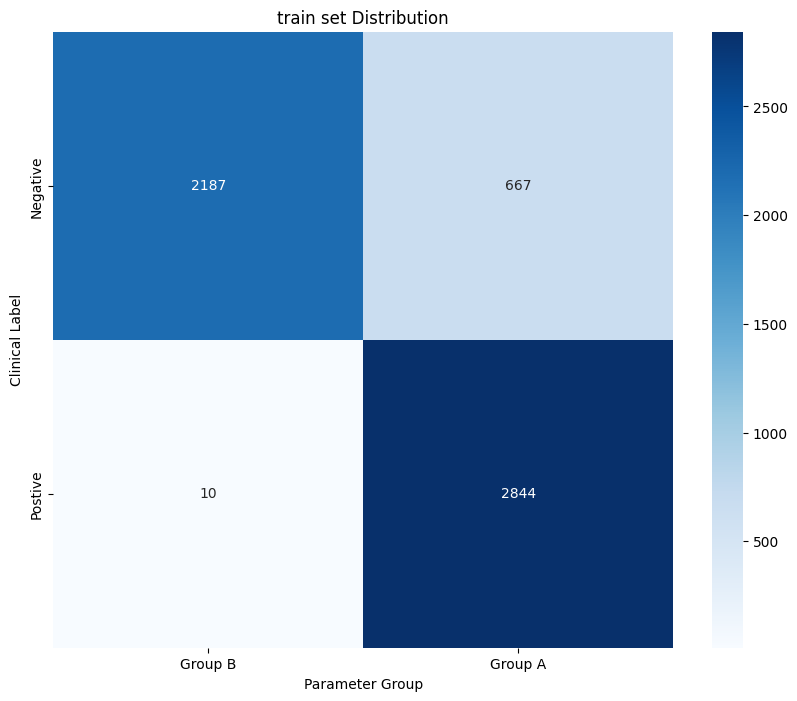

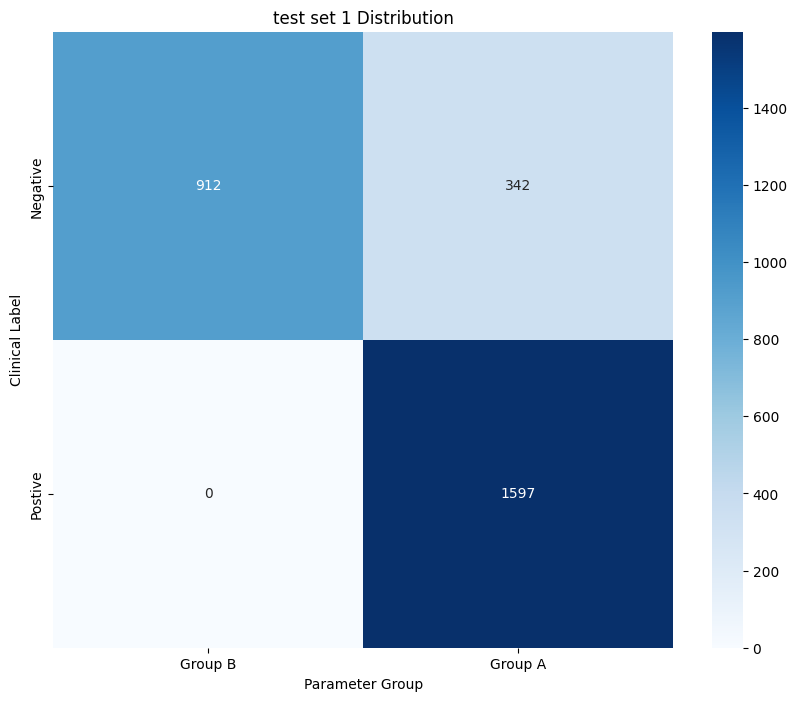

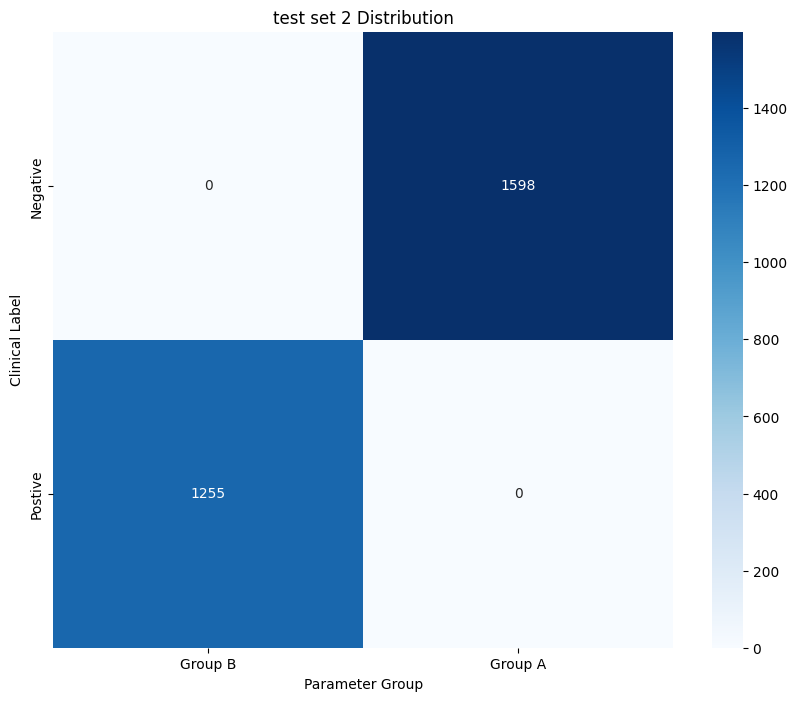

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_a_function(pl, dl, name):
    diagnose_labels = ['Negative', 'Postive']
    parameter_labels = ['Group B', 'Group A']   
    confusion_matrix = [[0]*2 for _ in range(2)]
    for i in range(len(dl)):
        diagnosis = dl[i]
        parameter = pl[i]
        confusion_matrix[diagnosis][parameter] += 1

    # 繪製熱圖
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=parameter_labels, yticklabels=diagnose_labels)
    plt.xlabel('Parameter Group')
    plt.ylabel('Clinical Label')
    plt.title(name+' Distribution')
    plt.show()
    
plot_a_function(train_pl_list,train_y_list,"train set")
plot_a_function(test1_pl_list,test1_y_list, "test set 1")
plot_a_function(test2_pl_list,test2_y_list, "test set 2")

In [15]:
#2379 579
#1264 1872

In [16]:
import random
def shuffle(list1,list2):
    zipped_lists = list(zip(list1, list2))
    random.shuffle(zipped_lists)
    list1_shuffled, list2_shuffled = zip(*zipped_lists)
    list1_shuffled = list(list1_shuffled)
    list2_shuffled = list(list2_shuffled)
    return list1_shuffled, list2_shuffled 

In [17]:
train_x_list,train_y_list = shuffle(train_x_list,train_y_list)
test1_x_list,test1_y_list = shuffle(test1_x_list,test1_y_list)
test2_x_list,test2_y_list = shuffle(test2_x_list,test2_y_list)

In [19]:
X = np.array(train_x_list) 
X_train = X.reshape((-1, 256, 256, 1)) 
y_train = np.array(train_y_list) 

X = np.array(test1_x_list) 
X_val = X.reshape((-1, 256, 256, 1)) 
y_val = np.array(test1_y_list) 

X = np.array(test2_x_list) 
X_test = X.reshape((-1, 256, 256, 1)) 
y_test = np.array(test2_y_list) 


In [ ]:
model_resnet50_conf = build_resnet50_v2_model()
model_resnet50_conf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

for j in range (20):
        model_resnet50_conf.fit(X_train, y_train, epochs=1, validation_data=(X_val, y_val))
        test_loss, test_acc = model_resnet50_conf.evaluate(X_test, y_test)
        print(f"Test accuracy: {test_acc:.4f}")

90/90 [==============================] - 72s 797ms/step - loss: 0.8110 - accuracy: 0.4585
Test accuracy: 0.4585
90/90 [==============================] - 73s 816ms/step - loss: 0.8414 - accuracy: 0.4402
Test accuracy: 0.4402
90/90 [==============================] - 74s 827ms/step - loss: 0.8640 - accuracy: 0.4522
Test accuracy: 0.4522
90/90 [==============================] - 71s 783ms/step - loss: 0.8881 - accuracy: 0.4318
Test accuracy: 0.4318
90/90 [==============================] - 73s 807ms/step - loss: 0.9210 - accuracy: 0.4259
Test accuracy: 0.4259
90/90 [==============================] - 70s 772ms/step - loss: 0.8427 - accuracy: 0.4511
Test accuracy: 0.4511
90/90 [==============================] - 70s 779ms/step - loss: 0.8781 - accuracy: 0.4620
Test accuracy: 0.4620
90/90 [==============================] - 71s 785ms/step - loss: 1.0170 - accuracy: 0.4343
Test accuracy: 0.4343
90/90 [==============================] - 71s 786ms/step - loss: 0.8899 - accuracy: 0.4525
Test accuracy: